In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager

# Portfolio 2 - The Rescorla-Wagner Model

In this portfolio, we are going to implement the Rescorla-Wagner model to simulate the behavior of agents interacting with environments that can have different levels of volatility. The Rescorla-Wagner model is a model of classical conditioning in which learning occurs in response to a prediction error. The model itself is a simple algebraic equation describing how associative values between a stimulus and an outcome are updated via error correction. 

This exercise will also introduce you to concepts like *learning rate*, *prediction error*, *volatility*, and *uncertainty* that are central in the reinforcement learning literature and computational psychiatry.

It is recommended that you first explore some resources to get a good intuition of the model before moving to the implementation part. The following videos are good introduction to the core concepts: [video-1](https://www.youtube.com/watch?v=D8b-cflPpec), [video-2](https://www.youtube.com/watch?v=CXrMtA1eNvQ).

**Additional resources**

> [Wikipedia](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model)

> [Scholarpedia](http://www.scholarpedia.org/article/Rescorla-Wagner_model)

> Sutton, R. & Barto, A. (2018). Reinforcement learning: an introduction. Cambridge, Massachusetts London, England: The MIT Press. *14.2.2. The Rescorla-Wagner Model*.

* [BayesCog Summer 2020 Lecture 09 - Intro to cognitive modeling & Rescorla-Wagner model](https://www.youtube.com/watch?v=tXFKYWx6c3k)
* [BayesCog Summer 2020 Lecture 10 - Implementing Rescorla-Wagner in Stan](https://www.youtube.com/watch?v=M69theIxI3g)

## Learning rate

In this exercise, we will create a simple version of the Rescorla-Wagner model that can update the associative value of a stimulus based on the prediction error of the outcome. We would like to reproduce the following figure from [Pulcu & Browning (2019)](https://doi.org/10.1016/j.tics.2019.07.007): 

![title](https://marlin-prod.literatumonline.com/cms/attachment/cdba6dca-87e1-480b-b7ee-d6f554ba8a72/gr1.jpg)

The core idea here is that task volatility (the rapid change of probability outcomes associated with conditioned stimuli) requires an adaptation of the learning rate of a basic (Rescorla-Wagner) reinforcement learning model. You are going to demonstrate that by simulating the performances of 2 agents (high and low learning rate) performing 2 tasks (high and low cat volatility).

Our agent cannot tell beforehand if the cat will scratch him or not, but he can learn from previous experience and update his expectation that he will be scratched in the future. Two key parameters are guiding the value update: the *prediction error* and the *learning rate*.

The *prediction error* is parameterized as:

$$ PE_{t-1} = R_{t-1} - V_{t-1} $$

Updating the value function is defined by:

$$ V_{t} = V_{t-1} + \alpha * PE $$

where $R$ is the outcome, $V$ is the associative strength between the CS and the outcome, and $\alpha$ is the learning rate.

## Exercise

You should create a Python class named `RescorlaWagner`, this class should have 3 core methods: 
* `response()` will generate the agent decision (e.g. stroke the cat or not).
* `update()` will update the outcome (did the cat scratch the agent or not, update the prediction for the next trial).
* `plot()` will plot the result from the entire experiment (hidden probability, responses, and associative value).

The final plot might look like something like this (this is just for illustration, the final traces can differ):
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/learningRate.png)

All data and relevant parameters should be stored in the class attributes. All methods should be documented following the Matplotlib standard (see [here](https://matplotlib.org/stable/devel/documenting_mpl.html)). You cannot import any additional package (just use Numpy and Matplotlib).

The two cat volatility levels are given by the following vectors:

In [4]:
volatileCat = np.repeat(
    np.array([0.5, 0.8, 0.1, 0.8, 0.1, 0.8, 0.1, 0.8, 0.1, 0.8]),
    10, axis=0)

stableCat = np.repeat(
    np.array([0.5, 0.8, 0.1, 0.8]),
    25, axis=0)

In [6]:
# create Rescorla Wagner class. 
class RescorlaWagner:
    """Class for Rescorla Wagner Reinforcement Learning. 
    """    
    def __init__(self, cat_vector, α, name, V = 0.5):
        """Initializes the class. 

        Args:
            cat_vector (np.Array): State of the probabilities
            name (string): Name for plotting functions later
            V (float, optional): Starting value of variables. Defaults to 0.5.
        """                
        self.cat_vector = cat_vector # will hold the cat data. 
        self.α = α # will hold the agent learning rate. 
        self.V = V
        self.V_data = None 
        self.response_data = None
        self.name = name
        
    def response(self):
        """Function for getting a response of the agent given its current internal evaluation of the world.

        Returns:
            Decision (int): 0 or 1, sampled from a binomial distribution given the current V of the agent.
        """        
        # make a decision
        decision = np.random.binomial(1, self.V) 
        
        # return the value
        return decision
        
    def update(self, prob): 
        """Function for updating the current internal model (V).

        Args:
            prob (float): Probability with which the binomial distribution is specified.

        Returns:
            V (float): The current V of the agent. Note that this is also updated in the class, but is also returned for plotting purposes later.
        """        
        # 1. did the cat scratch 
        R = np.random.binomial(1, prob) 
    
        # 2. prediction error
        PE = R - self.V 
        
        # 3. update internal state. 
        self.V += self.α * PE
        
        # return
        return self.V
    
    def run_sim(self):
        """Runs the simulation of the agents over all timesteps.
        """        
           
        data = [(self.response(), self.update(prob)) for prob in self.cat_vector]
        self.response_data, self.V_data = list(zip(*data))
    
    def get_optimality(self): 
        """Using MSE, find the distance between V and the real value of the external world

        Returns:
            MSE(float64): Mean distance between V and "cat_vector"
        """        
        
        if not self.V_data:
            self.run_sim() 
            
        optimality = [abs(self.cat_vector[i]-self.V_data[i]) for i in range(len(self.cat_vector))]
        return (sum(optimality)/len(optimality))
        
    def plot_something(self, ax=None):
        """Plots the result of the simulation. If the simulation has not been run, this will be done as the first step.

        Args:
            ax (AxesSubplot, optional): Fancy way of getting plotting to work across agents. Defaults to None.

        Returns:
            AxesSubplot: The plot.
        """        
        
        if not self.V_data: #if the simulation has not done, do it now
            self.run_sim()
        
        x = [i for i in range(len(self.cat_vector))] #index vector for plotting
        
        ax = ax or plt.gca()
        ax.scatter(x, self.response_data, alpha = 0.2, label = "response")
        ax.plot(x, self.V_data, label = "internal")
        ax.plot(x, self.cat_vector, label = "cat latent")
        ax.set(xlabel = "time", ylabel = "scratch prob.", title = r"$\bf{cat:}$" + f" {self.name}" + " "*5 + r"$\bf{learning rate:}$ " + f"{self.α}")

        return ax

     

Different conditions: 


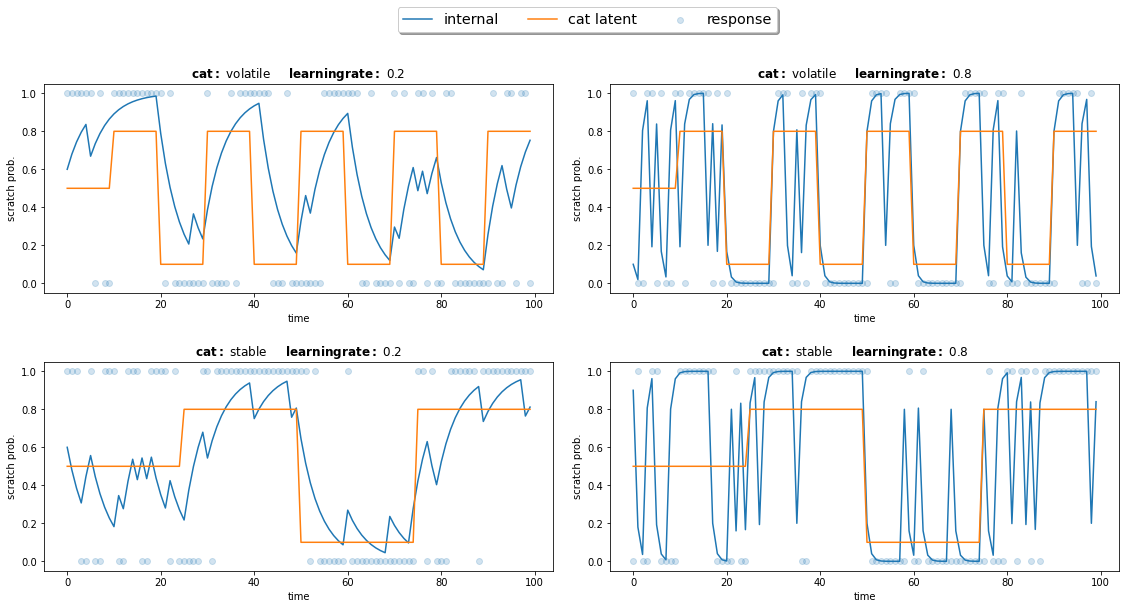

In [8]:
# task (1). 
name = ["volatile", "stable"]
cats = [volatileCat, stableCat]
alphas = [0.2, 0.8]

# loop stuff
fig, axes = plt.subplots(2,2, figsize = (16, 8))
for cat in range(len(cats)): 
    for alpha in range(len(alphas)): 
        agent = RescorlaWagner(cats[cat], alphas[alpha], name[cat])
        agent.plot_something(axes[cat, alpha])
handles, labels = axes[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper left",
           bbox_to_anchor=(0.35, 1.08),
           fancybox=True, shadow=True, ncol=3,
          fontsize = "x-large")
fig.tight_layout(pad=2.0)
plt.show()

In [10]:
# task (2) 

## create crazy loop (or dct-comp?)
def find_optimum(cat, name, N = 101):
    """Function for getting estimates of optimality for different alphas.

    Args:
        cat (np.array): The probability space that the agent is trying to learn. 
        name (str): string for plotting purposes. The class needs this argument to work.
        N (int, optional): How many different alphas to simulate. Defaults to 101.

    Returns:
        dict: Dictionary containing the optimality score for different alphas.
    """    
    
    alphas = np.linspace(0, 1, N)
    optimality_score = 0
    dct = {}
    for alpha in alphas: 
        for i in range(N): 
            agent = RescorlaWagner(cat, alpha, name)
            optimality_score += agent.get_optimality()
        final = optimality_score / N
        dct[alpha] = final
        optimality_score = 0
    
    return dct
    

In [12]:
## recall the data
name = ["volatile", "stable"]
cats = [volatileCat, stableCat]

In [14]:
volatile_dct = find_optimum(volatileCat, "volatile")
stable_dct = find_optimum(stableCat, "stable")

In [16]:
def get_min(dct): 
    """Given a dictionary, find the minimum and the index of the minimum.

    Args:
        dct (dictionary): Dictionary containing values. Assumes these are either integers or floats.

    Returns:
        (x, y): Returns the index (x) and the value (y)
    """    
    y = min(dct.values())
    x = min(dct, key = dct.get)
    return x, y

In [18]:
def plot_optimality(volatile, stable, **kwargs): 
    """Plot the optimality of different learning rates between volatile and stable environments. The

    Args:
        volatile (np.Array): Array of the volatile setting. 
        stable (np.Array): Array of the stable setting. 
    """    
    
    # calculate the mean cat
    mean = {}
    for i in volatile: 
        mean[i] = (volatile[i] + stable[i])/2
    
    # find minimum and index. 
    volatile_x, volatile_y = get_min(volatile)
    stable_x, stable_y = get_min(stable)
    mean_x, mean_y = get_min(mean)
    
    # first part 
    plt.figure(figsize = (16, 8))
    plt.plot(list(volatile.keys()), list(volatile.values()), label = f'{volatile=}'.split('=')[0] + f': {round(volatile_x, 2)}')
    plt.plot(list(stable.keys()), list(stable.values()), label = f'{stable=}'.split('=')[0] + f': {round(stable_x, 2)}')
    plt.plot(list(mean.keys()), list(mean.values()), label = f"mean: {round(mean_x, 2)}")
    plt.vlines(volatile_x, 0, volatile_y, color = "C0") # need this. 
    plt.vlines(stable_x, 0, stable_y, color = "C1")
    plt.vlines(mean_x, 0, mean_y, color = "C2")
    plt.legend(fancybox=True, shadow=True, ncol=3, fontsize = "x-large")
    plt.show()

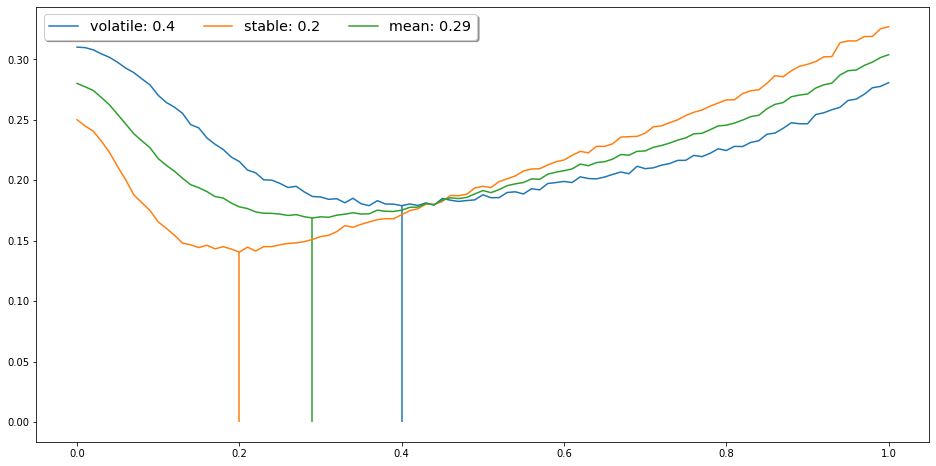

In [20]:
plot_optimality(volatile_dct, stable_dct)

1) You should use two agents and make them learn the underlying associations using a high and a low learning rate (e.g 0.2 vs 0.8). You should have four plots in total (learning rate * task variability).

2) How can we find an optimal learning rate that would maximize the outcome (stroke the cat without being scratched most of the time)? Run 1000 simulations and use a robust estimate.

## Blocking

We have built from the previous exercise an agent that can update its expectation about future outcomes associated with a stimulus. However, one of the main strengths of the Rescorla-Wagner model, and the reason why it is still used as a baseline reference for a reinforcement learning task, is that it can explain results that occur under more complex setups like blocking.

Blocking happens when many CSs are presented in association with an outcome, but only some of them show a conditioning response. In the previous example, we used only one CS (the cat) that was always presented, and the outcome probability was varying through time. Here, we are going to present 2 stimuli ($A$ and $X$).

$V_{A}$, $V_{X}$ and $V_{AX}$ denote the associative strength of stimuli $A$, $X$ and the compound $AX$. Suppose that on a trial the compound $CS_{AX}$ is followed by a $US$ laballed stimulus $Y$. Then the associative strengths of the stimulus components change according to these expression:

$$ \Delta V_{A} = \alpha_{A}\beta_{Y}(R_{Y}-V_{AX})$$
$$ \Delta V_{X} = \alpha_{X}\beta_{Y}(R_{Y}-V_{AX})$$

Here, $V_{AX} = V_{A} + V_{X}$. $\alpha$ refers to the $CS$ salience and $\beta$ refers to the $US$ salience.

In [22]:
unconditioned = np.repeat(
    np.array([0, 1, 0, 1, 0, 0]),
    10, axis=0)

stimulusA = np.repeat(
    np.array([0, 1, 0, 1, 0, 0]),
    10, axis=0)

stimulusX = np.repeat(
    np.array([0, 0, 0, 1, 0, 1]),
    10, axis=0)

In [24]:
# create Rescorla Wagner class. 
class MostWagner:
    """Class for investigating blocking. 
    """    
    def __init__(self, Y, A, X, learning_rate, Va = 0, Vx = 0):
        """Initializing the agent. 

        Args:
            Y (np.array): Numpy array of the unconditioned stimuli.
            A (np.array): Numpy array of the stimuli "A"
            X (np.array): Numpy array of the stimuli "X"
            learning_rate (float): learning rate for updating the value of Va and Vx. 
            Va (float/int, optional): Starting Value of Va. Defaults to 0.
            Vx (float/int, optional): Starting Value of Vx. Defaults to 0.
        """        
        self.Y = Y #Uncondittioned stimulus 
        self.A = A #Stimuli 1
        self.X = X #Stimuli 2
        self.Va = Va 
        self.Vx = Vx  
        self.Vax = self.Vx + self.Va
        self.learning_rate = learning_rate

         
    def update(self, t_step): 
        """Updating function for the agent given a timestep. 

        Args:
            t_step (int): Timestep for indexing the different arrays. 

        Returns:
            tuple: A tuple containing (1) the value associated with Va, (2) the value associated with Vx and finally (3) the value of Vax respectively. 
        """
        # allow for randomness. Note that if A, X and Y are binary, this will be deterministic.        
        A =  np.random.binomial(1, self.A[t_step])
        X =  np.random.binomial(1, self.X[t_step])
        Y =  np.random.binomial(1, self.Y[t_step])

        # update values 
        self.Va += A * Y * (1 - self.Vax) * self.learning_rate
        self.Vx += X * Y * (1 - self.Vax) * self.learning_rate
        self.Vax = self.Vx + self.Va

        return (round(self.Va, 6), round(self.Vx, 6), round(self.Vax, 6))


    def run_sim(self):
        """Run the simulation across all timesteps.
        """        
        self.data = [self.update(i) for i in range(len(self.X))]
            
   
     

In [26]:
def many_plot(alphas = [0.3, 0.6, 0.9], stim_a = stimulusA , stim_x = stimulusX, y = unconditioned):
    """Plotting function for getting the five rows of the final plot. 

    Args:
        alphas (list, optional): List of learning rates. Defaults to [0.3, 0.6, 0.9].
        stim_a (np.array, optional): Numpy array of stimulus "A". Defaults to stimulusA.
        stim_x (np.array, optional): Numpy array of stimulus "X". Defaults to stimulusX.
        y (np.array, optional): Numpy array of unconditioned stimuli. Defaults to unconditioned.

    Returns:
        fig: Returns the plot.
    """    
    fig, ax = plt.subplots(5,1, figsize = (12,24))
    titles = [r"Stimulus $A$", r"Stimulus $X$", "Unconditioned Stimulus", r"$V_A$", r"$V_X$"]

    ax[0].plot(stim_a, color = "C7", linewidth = 3)
    ax[1].plot(stim_x, color = "C8", linewidth = 3)
    ax[2].plot(y, color = "C9", linewidth = 3)
    ax[0].set(xlabel = r"$t$", ylabel = "state")
    ax[1].set(xlabel = r"$t$", ylabel = "state")
    ax[2].set(xlabel = r"$t$", ylabel = "state")

    for alpha in alphas:
        placeholder = MostWagner(y, stim_a, stim_x, alpha)
        placeholder.run_sim()
        a,x,_ = list(zip(*placeholder.data))
        ax[3].plot(a, label = f"{alpha}", linewidth = 3)
        ax[4].plot(x, label = f"{alpha}", linewidth = 3)
    ax[3].legend(loc = "upper left")
    ax[4].legend(loc = "upper left")
    ax[3].set(xlabel = r"$t$", ylabel = "asso.")
    ax[4].set(xlabel = r"$t$", ylabel = "asso.")
    ax[3].set_ylim(0,1)
    ax[4].set_ylim(0,1)
    
    for i, ele in enumerate(ax):
        ele.grid()
        ele.set_title(titles[i], fontsize = 15)

    fig.tight_layout(pad=2.0)
    
    return fig


In [28]:
def many_plot_sim(alphas = [0.3, 0.6, 0.9], stim_a = stimulusA , stim_x = stimulusX, y = unconditioned):
    """Adjusting the many 

    Args:
        alphas (list, optional): List of learning rates. Defaults to [0.3, 0.6, 0.9].
        stim_a (np.array, optional): Numpy array of stimulus "A". Defaults to stimulusA.
        stim_x (np.array, optional): Numpy array of stimulus "X". Defaults to stimulusX.
        y (np.array, optional): Numpy array of unconditioned stimuli. Defaults to unconditioned.

    Returns:
        fig: Returns the plot.
    """    

    fig, ax = plt.subplots(5,1, figsize = (12,24))
    titles = [r"Stimulus $A$", r"Stimulus $X$", "Unconditioned Stimulus", r"$V_A$", r"$V_X$"]

    ax[0].plot(stim_a, color = "C7", linewidth = 3)
    ax[1].plot(stim_x, color = "C8", linewidth = 3)
    ax[2].plot(y, color = "C9", linewidth = 3)
    ax[0].set(xlabel = r"$t$", ylabel = "state")
    ax[1].set(xlabel = r"$t$", ylabel = "state")
    ax[2].set(xlabel = r"$t$", ylabel = "state")


    #container for data
    data_dict = {} 
    
    #run through all alphas
    for alpha in alphas:
        
        # make 100 simulations
        for i in range(100):

            placeholder = MostWagner(y, stim_a, stim_x, alpha)
            placeholder.run_sim()
            a,x,_ = np.array(list(zip(*placeholder.data)))
            
            #hack for getting append to work in numpy
            if i == 0:
                container_a = a 
                container_x = x 
                continue

            #append the simulation
            container_a = np.append(container_a, a)
            container_x = np.append(container_x, x)
        
        #reshape arrays
        container_a = container_a.reshape(100,60)
        container_x = container_x.reshape(100,60)
        
        #append to data dict
        data_dict[alpha] = {
            "a": container_a,
            "x": container_x
        }
        
        #get the mean
        ax[3].plot(data_dict[alpha]["a"].mean(axis = 0), label = f"{alpha}", linewidth = 3)

        #shade for 2 standard deviations
        ax[3].fill_between(
            list(range(len(stim_a))), 
            data_dict[alpha]["a"].mean(axis = 0)-1.96 *data_dict[alpha]["a"].std(axis = 0),
            data_dict[alpha]["a"].mean(axis = 0)+1.96 *data_dict[alpha]["a"].std(axis = 0),
            alpha = 0.15
            )
        #get the mean
        ax[4].plot(data_dict[alpha]["x"].mean(axis = 0), label = f"{alpha}", linewidth = 3)
        
        #shade for 2 standard deviations
        ax[4].fill_between(
            list(range(len(stim_a))), 
            data_dict[alpha]["x"].mean(axis = 0)-1.96 *data_dict[alpha]["x"].std(axis = 0),
            data_dict[alpha]["x"].mean(axis = 0)+1.96 *data_dict[alpha]["x"].std(axis = 0),
            alpha = 0.15
            )
            
    ax[3].legend(loc = "upper left")
    ax[4].legend(loc = "upper left")
    ax[3].set(xlabel = r"$t$", ylabel = "asso.")
    ax[4].set(xlabel = r"$t$", ylabel = "asso.")
    ax[3].set_ylim(0,1)
    ax[4].set_ylim(0,1)
    
    for i, ele in enumerate(ax):
        ele.grid()
        ele.set_title(titles[i], fontsize = 15)

    fig.tight_layout(pad=2.0)
    
    return fig


## Exercise

* Using the previous `RescorlaWagner` class, make some modifications that will let it use a compound of CS variables (here $A$ and $X$) to predict the unconditioned stimulus. Because the association $A-Y$ is learned first, we should observe a *blocking* of $X-Y$ when it is later presented.

* Create a figure synthesizing the main result from this task, demonstrating that the Rescorla-Wagner model can explain the blocking effect. Ideally, the figure should have 5 rows:
* Unconditioned stimulus $Y$
* Stimulus $A$
* Stimulus $X$
* $V_{A}$
* $V_{X}$

In [30]:
## STOCHASTIC VERSION:

unconditioned_prob = np.repeat(
    np.array([0.1, 0.9, 0.1, 0.9, 0.1, 0.1]),
    10, axis=0)

stimulusA_prob = np.repeat(
    np.array([0.1, 0.9, 0.1, 0.9, 0.1, 0.1]),
    10, axis=0)

stimulusX_prob = np.repeat(
    np.array([0.1, 0.1, 0.1, 0.9, 0.1, 0.9]),
    10, axis=0)



## Deterministic plotting

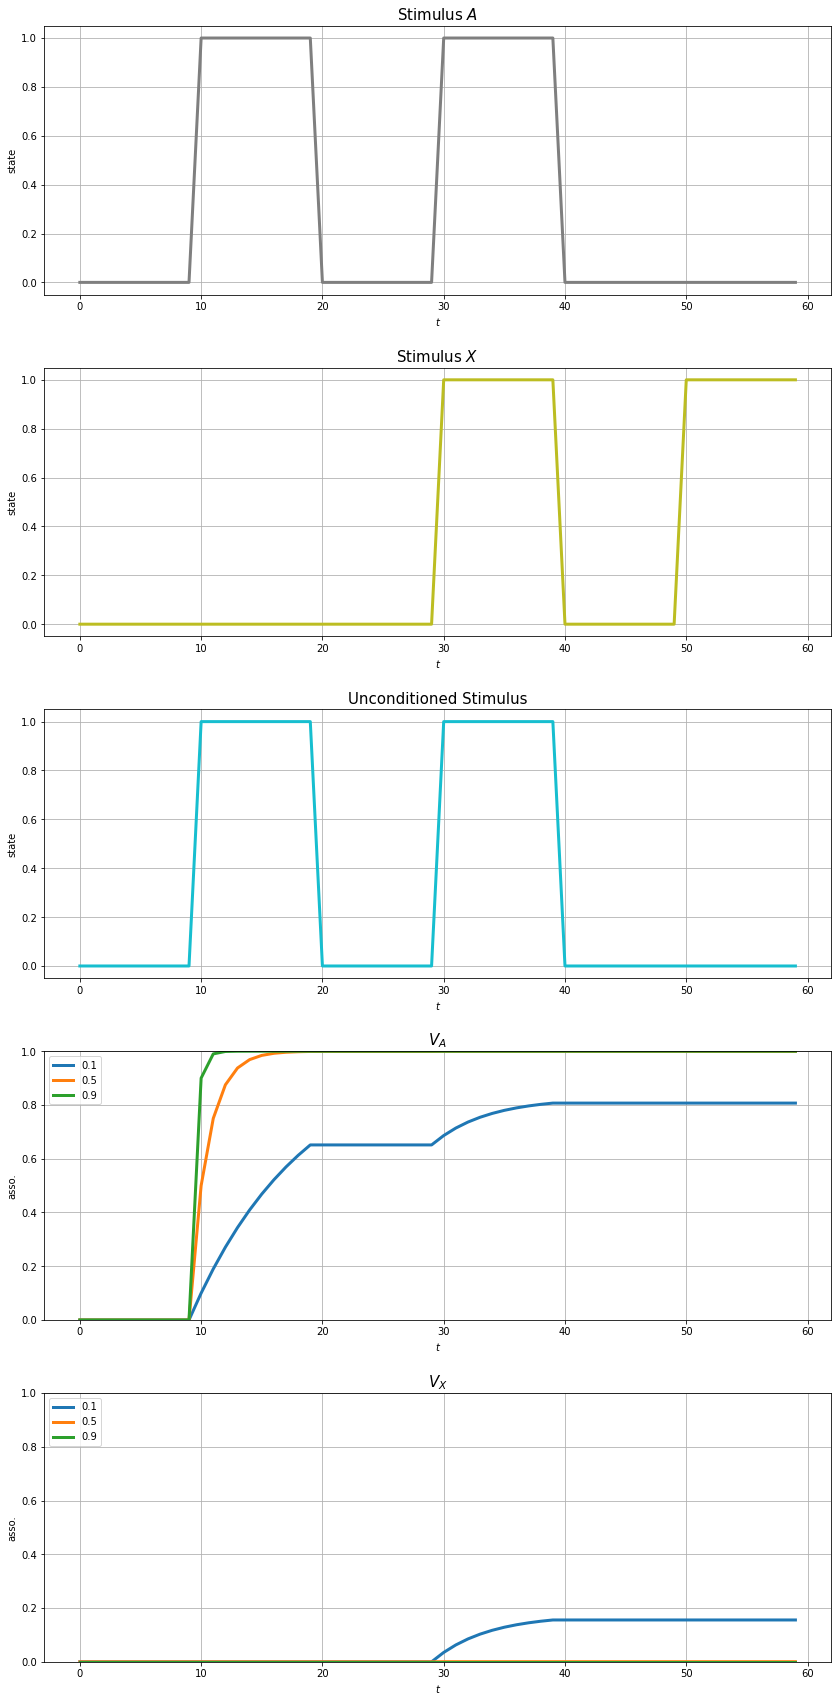

In [32]:
many_plot(alphas = [0.1,0.5,0.9]);

## Stochastic Plotting

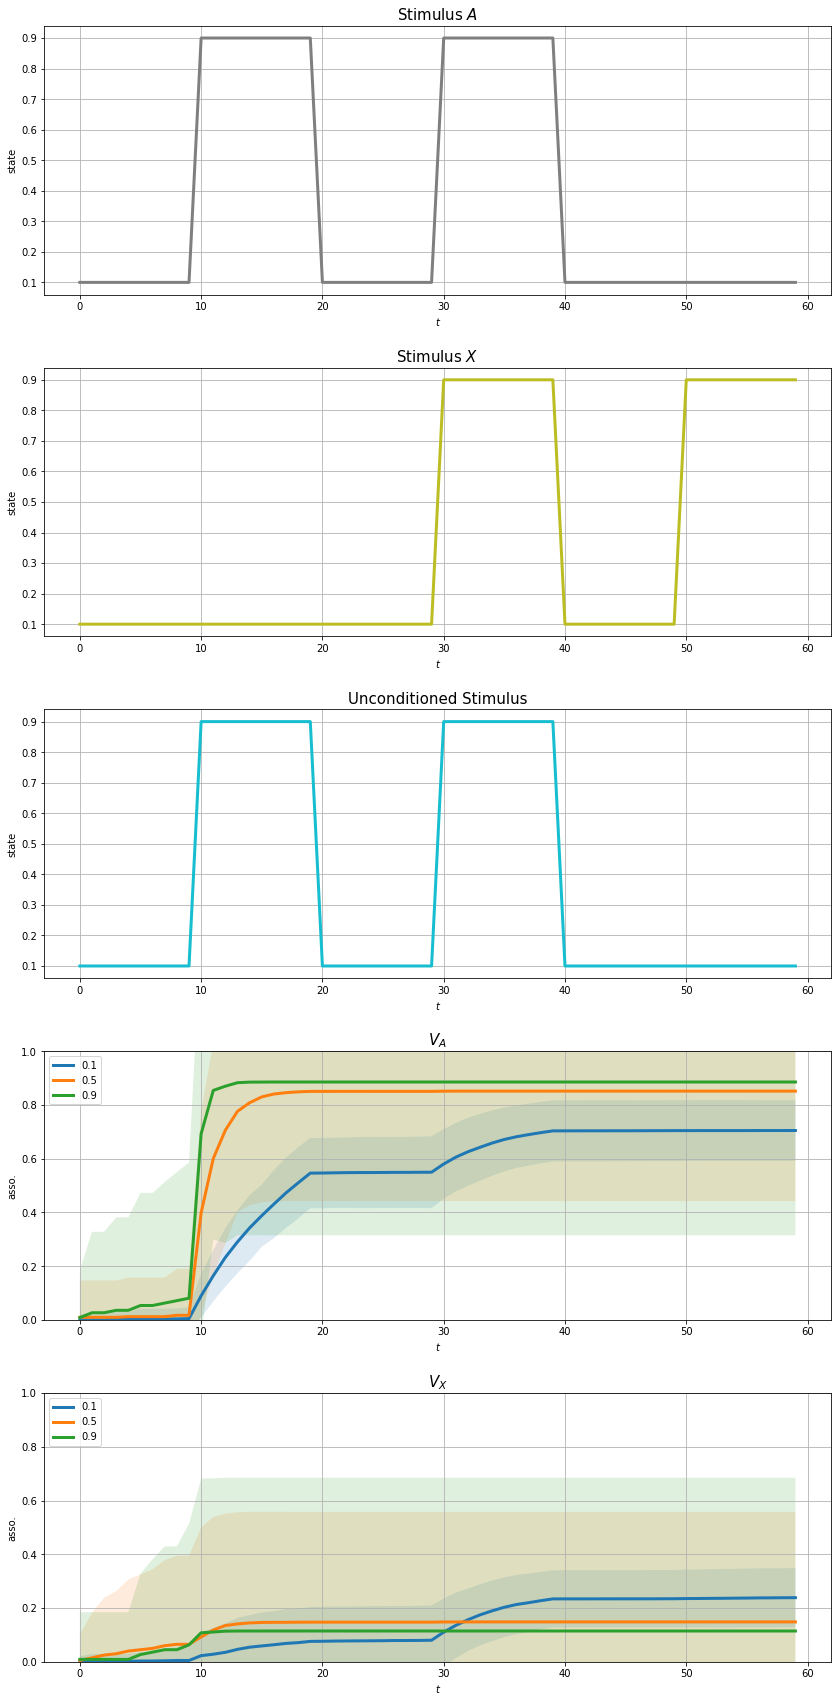

In [34]:
many_plot_sim(alphas = [0.1,0.5,0.9], stim_a=stimulusA_prob, stim_x=stimulusX_prob, y = unconditioned_prob);